Importing libraries

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
import json

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Reading the files into training and validation datasets with a 80%-20% split

In [3]:
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(
    'Datasets/VERA/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both'
)

Found 2200 files belonging to 110 classes.
Using 1760 files for training.
Using 440 files for validation.


In [4]:
train_batches = len(train_dataset)

test_size = 0.2

# Calculate sizes for 80-20 split
train_size = int((1 - test_size) * train_batches)
test_size = int(test_size * train_batches)

# Split the dataset
test_dataset = train_dataset.skip(train_batches - test_size)
train_dataset = train_dataset.take(train_size)

In [5]:
def get_dataset_size(dataset):
    num_batches = len(dataset)
    return num_batches * 32

print(f"Total number of samples in train_dataset: {get_dataset_size(train_dataset)} ({len(train_dataset)} batches of 32)")
print(f"Total number of samples in validation_dataset: {get_dataset_size(val_dataset)} ({len(val_dataset)} batches of 32)")
print(f"Total number of samples in test_dataset: {get_dataset_size(test_dataset)} ({len(test_dataset)} batches of 32)")

Total number of samples in train_dataset: 1408 (44 batches of 32)
Total number of samples in validation_dataset: 448 (14 batches of 32)
Total number of samples in test_dataset: 352 (11 batches of 32)


Prefetching data into GPU memory to optimize training process

In [6]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

Visualizing some training images

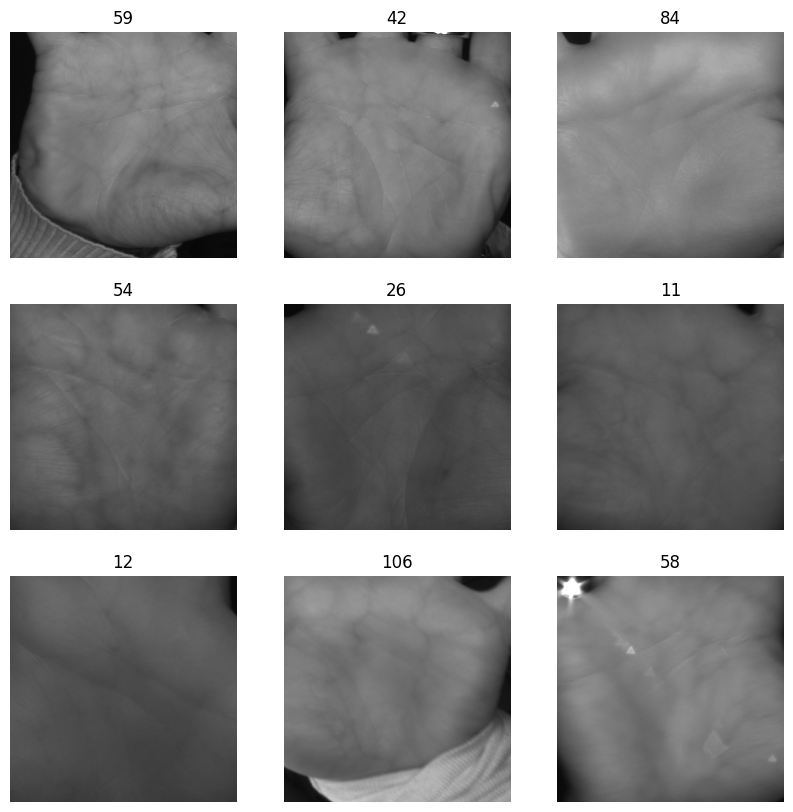

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Creating data augmentation layer 

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomHeight(0.1),
        layers.RandomWidth(0.1),
    ]
)

Visualizing the data augmentations on a random training image

In [9]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_dataset.take(1):
#     for i in range(9):
#         augmented_images = data_augmentation(images)
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(augmented_images[0].numpy().astype("uint8"))
#         plt.axis("off")

Define some key constants

In [10]:
num_classes = 110
image_size = (224, 224, 3)

Defining function to return AlexNet Model with reduced number of filters as per research paper

In [11]:
def make_alexnet_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Layer 1: Convolutional + Max Pooling
    # x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), strides=(4, 4), activation='relu', padding='valid')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)
    x = layers.BatchNormalization()(x)

    # Layer 2: Convolutional + Max Pooling
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)
    x = layers.BatchNormalization()(x)

    # Layer 3: Three Convolutional Layers
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Layer 4: Max Pooling
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return keras.Model(inputs, outputs)


Defining function to return VGG16 Model with reduced number of filters as per research paper

In [12]:
def make_vgg16_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 3
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

Defining function to return VGG19 Model with reduced number of filters as per research paper

In [13]:
def make_vgg19_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 3
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)


Training each model

In [14]:
from tqdm import tqdm
num_epochs = 30

models = {
    "AlexNet": make_alexnet_model(input_shape=image_size, num_classes=num_classes),
    "VGG16": make_vgg16_model(input_shape=image_size, num_classes=num_classes),
    "VGG19": make_vgg19_model(input_shape=image_size, num_classes=num_classes),
}

model_histories = {}

for name, model in models.items():
    print(f'\x1b[34mTraining {name} Model...\x1b[0m')
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    start = time.time()
        
    # Wrap model.fit with tqdm for a progress bar
    progress_bar = tqdm(total=num_epochs, position=0, leave=True)
    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: progress_bar.update(1)),
        ]
    )
    progress_bar.close()
    
    model_histories[name] = history
    
    end = time.time()
    print(f'Finished training {name} in {end-start:.2f}s\n')


Training AlexNet Model...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
44/44 [==============================] - ETA: 0s - loss: 4.6228 - accuracy: 0.0263

  3%|▎         | 1/30 [00:05<02:30,  5.19s/it]

44/44 [==============================] - 5s 43ms/step - loss: 4.6228 - accuracy: 0.0263 - val_loss: 4.9700 - val_accuracy: 0.0045
Epoch 2/30
44/44 [==============================] - ETA: 0s - loss: 4.0916 - accuracy: 0.0682

  7%|▋         | 2/30 [00:06<01:28,  3.15s/it]

44/44 [==============================] - 2s 35ms/step - loss: 4.0916 - accuracy: 0.0682 - val_loss: 4.9614 - val_accuracy: 0.0045
Epoch 3/30
43/44 [============================>.] - ETA: 0s - loss: 3.6756 - accuracy: 0.1286

 10%|█         | 3/30 [00:08<01:07,  2.51s/it]

44/44 [==============================] - 2s 36ms/step - loss: 3.6712 - accuracy: 0.1278 - val_loss: 4.6269 - val_accuracy: 0.0136
Epoch 4/30
43/44 [============================>.] - ETA: 0s - loss: 3.3152 - accuracy: 0.1890

 13%|█▎        | 4/30 [00:10<00:57,  2.20s/it]

44/44 [==============================] - 2s 36ms/step - loss: 3.3239 - accuracy: 0.1868 - val_loss: 3.7537 - val_accuracy: 0.1091
Epoch 5/30
43/44 [============================>.] - ETA: 0s - loss: 3.1320 - accuracy: 0.2195

 17%|█▋        | 5/30 [00:12<00:51,  2.06s/it]

44/44 [==============================] - 2s 37ms/step - loss: 3.1311 - accuracy: 0.2223 - val_loss: 3.2470 - val_accuracy: 0.2091
Epoch 6/30
43/44 [============================>.] - ETA: 0s - loss: 2.8025 - accuracy: 0.2696

 20%|██        | 6/30 [00:13<00:46,  1.95s/it]

44/44 [==============================] - 2s 35ms/step - loss: 2.8103 - accuracy: 0.2699 - val_loss: 3.1368 - val_accuracy: 0.2318
Epoch 7/30
43/44 [============================>.] - ETA: 0s - loss: 2.5536 - accuracy: 0.3379

 23%|██▎       | 7/30 [00:15<00:42,  1.86s/it]

44/44 [==============================] - 2s 34ms/step - loss: 2.5641 - accuracy: 0.3324 - val_loss: 3.6438 - val_accuracy: 0.1432
Epoch 8/30
43/44 [============================>.] - ETA: 0s - loss: 2.2679 - accuracy: 0.3961

 27%|██▋       | 8/30 [00:17<00:39,  1.81s/it]

44/44 [==============================] - 2s 35ms/step - loss: 2.2667 - accuracy: 0.3963 - val_loss: 3.7998 - val_accuracy: 0.1227
Epoch 9/30
43/44 [============================>.] - ETA: 0s - loss: 2.0345 - accuracy: 0.4462

 30%|███       | 9/30 [00:19<00:37,  1.79s/it]

44/44 [==============================] - 2s 36ms/step - loss: 2.0319 - accuracy: 0.4474 - val_loss: 3.3287 - val_accuracy: 0.1773
Epoch 10/30
44/44 [==============================] - ETA: 0s - loss: 1.8031 - accuracy: 0.5028

 33%|███▎      | 10/30 [00:20<00:35,  1.78s/it]

44/44 [==============================] - 2s 36ms/step - loss: 1.8031 - accuracy: 0.5028 - val_loss: 3.0998 - val_accuracy: 0.2500
Epoch 11/30
43/44 [============================>.] - ETA: 0s - loss: 1.5473 - accuracy: 0.5719

 37%|███▋      | 11/30 [00:22<00:33,  1.79s/it]

44/44 [==============================] - 2s 37ms/step - loss: 1.5472 - accuracy: 0.5710 - val_loss: 3.4893 - val_accuracy: 0.2045
Epoch 12/30
44/44 [==============================] - ETA: 0s - loss: 1.3454 - accuracy: 0.6236

 40%|████      | 12/30 [00:24<00:33,  1.87s/it]

44/44 [==============================] - 2s 42ms/step - loss: 1.3454 - accuracy: 0.6236 - val_loss: 3.5266 - val_accuracy: 0.2114
Epoch 13/30
43/44 [============================>.] - ETA: 0s - loss: 1.2241 - accuracy: 0.6497

 43%|████▎     | 13/30 [00:26<00:31,  1.86s/it]

44/44 [==============================] - 2s 36ms/step - loss: 1.2220 - accuracy: 0.6513 - val_loss: 2.9243 - val_accuracy: 0.3159
Epoch 14/30
43/44 [============================>.] - ETA: 0s - loss: 0.9435 - accuracy: 0.7326

 47%|████▋     | 14/30 [00:28<00:29,  1.82s/it]

44/44 [==============================] - 2s 36ms/step - loss: 0.9484 - accuracy: 0.7308 - val_loss: 2.9777 - val_accuracy: 0.3136
Epoch 15/30
44/44 [==============================] - ETA: 0s - loss: 0.8264 - accuracy: 0.7706

 50%|█████     | 15/30 [00:30<00:27,  1.87s/it]

44/44 [==============================] - 2s 41ms/step - loss: 0.8264 - accuracy: 0.7706 - val_loss: 2.8720 - val_accuracy: 0.3250
Epoch 16/30
43/44 [============================>.] - ETA: 0s - loss: 0.6343 - accuracy: 0.8176

 53%|█████▎    | 16/30 [00:31<00:25,  1.83s/it]

44/44 [==============================] - 2s 35ms/step - loss: 0.6426 - accuracy: 0.8161 - val_loss: 1.4165 - val_accuracy: 0.6977
Epoch 17/30
43/44 [============================>.] - ETA: 0s - loss: 0.5990 - accuracy: 0.8321

 57%|█████▋    | 17/30 [00:33<00:23,  1.84s/it]

44/44 [==============================] - 2s 38ms/step - loss: 0.5983 - accuracy: 0.8324 - val_loss: 2.7561 - val_accuracy: 0.4250
Epoch 18/30
43/44 [============================>.] - ETA: 0s - loss: 0.4894 - accuracy: 0.8590

 60%|██████    | 18/30 [00:35<00:22,  1.84s/it]

44/44 [==============================] - 2s 37ms/step - loss: 0.4882 - accuracy: 0.8587 - val_loss: 1.3015 - val_accuracy: 0.7409
Epoch 19/30
42/44 [===========================>..] - ETA: 0s - loss: 0.4437 - accuracy: 0.8780

 63%|██████▎   | 19/30 [00:37<00:19,  1.80s/it]

44/44 [==============================] - 2s 35ms/step - loss: 0.4465 - accuracy: 0.8771 - val_loss: 1.7531 - val_accuracy: 0.6045
Epoch 20/30
43/44 [============================>.] - ETA: 0s - loss: 0.3176 - accuracy: 0.9157

 67%|██████▋   | 20/30 [00:39<00:17,  1.78s/it]

44/44 [==============================] - 2s 36ms/step - loss: 0.3175 - accuracy: 0.9148 - val_loss: 1.1115 - val_accuracy: 0.8000
Epoch 21/30
44/44 [==============================] - ETA: 0s - loss: 0.3347 - accuracy: 0.8999

 70%|███████   | 21/30 [00:40<00:15,  1.76s/it]

44/44 [==============================] - 2s 35ms/step - loss: 0.3347 - accuracy: 0.8999 - val_loss: 1.2750 - val_accuracy: 0.7955
Epoch 22/30
42/44 [===========================>..] - ETA: 0s - loss: 0.2333 - accuracy: 0.9397

 73%|███████▎  | 22/30 [00:42<00:13,  1.74s/it]

44/44 [==============================] - 2s 35ms/step - loss: 0.2445 - accuracy: 0.9382 - val_loss: 1.5828 - val_accuracy: 0.6591
Epoch 23/30
44/44 [==============================] - ETA: 0s - loss: 0.1849 - accuracy: 0.9538

 77%|███████▋  | 23/30 [00:44<00:12,  1.72s/it]

44/44 [==============================] - 2s 34ms/step - loss: 0.1849 - accuracy: 0.9538 - val_loss: 1.0671 - val_accuracy: 0.8432
Epoch 24/30
43/44 [============================>.] - ETA: 0s - loss: 0.1716 - accuracy: 0.9593

 80%|████████  | 24/30 [00:45<00:10,  1.70s/it]

44/44 [==============================] - 2s 34ms/step - loss: 0.1736 - accuracy: 0.9574 - val_loss: 1.0824 - val_accuracy: 0.8568
Epoch 25/30
42/44 [===========================>..] - ETA: 0s - loss: 0.1527 - accuracy: 0.9546

 83%|████████▎ | 25/30 [00:47<00:08,  1.69s/it]

44/44 [==============================] - 2s 35ms/step - loss: 0.1554 - accuracy: 0.9531 - val_loss: 1.3525 - val_accuracy: 0.7886
Epoch 26/30
42/44 [===========================>..] - ETA: 0s - loss: 0.1351 - accuracy: 0.9561

 87%|████████▋ | 26/30 [00:49<00:06,  1.68s/it]

44/44 [==============================] - 2s 34ms/step - loss: 0.1456 - accuracy: 0.9531 - val_loss: 1.2311 - val_accuracy: 0.7886
Epoch 27/30
44/44 [==============================] - ETA: 0s - loss: 0.1003 - accuracy: 0.9730

 90%|█████████ | 27/30 [00:50<00:05,  1.67s/it]

44/44 [==============================] - 2s 34ms/step - loss: 0.1003 - accuracy: 0.9730 - val_loss: 1.4418 - val_accuracy: 0.7205
Epoch 28/30
42/44 [===========================>..] - ETA: 0s - loss: 0.0910 - accuracy: 0.9702

 93%|█████████▎| 28/30 [00:52<00:03,  1.67s/it]

44/44 [==============================] - 2s 34ms/step - loss: 0.0929 - accuracy: 0.9695 - val_loss: 1.2883 - val_accuracy: 0.8023
Epoch 29/30
44/44 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.9695

 97%|█████████▋| 29/30 [00:54<00:01,  1.67s/it]

44/44 [==============================] - 2s 35ms/step - loss: 0.1049 - accuracy: 0.9695 - val_loss: 1.2068 - val_accuracy: 0.8182
Epoch 30/30
43/44 [============================>.] - ETA: 0s - loss: 0.1063 - accuracy: 0.9695

100%|██████████| 30/30 [00:55<00:00,  1.67s/it]

44/44 [==============================] - 2s 35ms/step - loss: 0.1102 - accuracy: 0.9673 - val_loss: 0.9945 - val_accuracy: 0.8750


100%|██████████| 30/30 [00:55<00:00,  1.86s/it]


Finished training AlexNet in 55.85s

Training VGG16 Model...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
44/44 [==============================] - ETA: 0s - loss: 5.7440 - accuracy: 0.0312

  3%|▎         | 1/30 [00:16<08:10, 16.90s/it]

44/44 [==============================] - 17s 264ms/step - loss: 5.7440 - accuracy: 0.0312 - val_loss: 4.7207 - val_accuracy: 0.0045
Epoch 2/30
44/44 [==============================] - ETA: 0s - loss: 4.3409 - accuracy: 0.0803

  7%|▋         | 2/30 [00:27<06:02, 12.94s/it]

44/44 [==============================] - 10s 228ms/step - loss: 4.3409 - accuracy: 0.0803 - val_loss: 4.7715 - val_accuracy: 0.0045
Epoch 3/30
44/44 [==============================] - ETA: 0s - loss: 3.7805 - accuracy: 0.1463

 10%|█         | 3/30 [00:37<05:15, 11.69s/it]

44/44 [==============================] - 10s 229ms/step - loss: 3.7805 - accuracy: 0.1463 - val_loss: 4.8810 - val_accuracy: 0.0045
Epoch 4/30
44/44 [==============================] - ETA: 0s - loss: 3.2224 - accuracy: 0.2401

 13%|█▎        | 4/30 [00:47<04:48, 11.10s/it]

44/44 [==============================] - 10s 228ms/step - loss: 3.2224 - accuracy: 0.2401 - val_loss: 4.8295 - val_accuracy: 0.0068
Epoch 5/30
44/44 [==============================] - ETA: 0s - loss: 2.8616 - accuracy: 0.3104

 17%|█▋        | 5/30 [00:57<04:29, 10.78s/it]

44/44 [==============================] - 10s 229ms/step - loss: 2.8616 - accuracy: 0.3104 - val_loss: 4.3939 - val_accuracy: 0.0295
Epoch 6/30
44/44 [==============================] - ETA: 0s - loss: 2.3235 - accuracy: 0.4027

 20%|██        | 6/30 [01:07<04:14, 10.62s/it]

44/44 [==============================] - 10s 231ms/step - loss: 2.3235 - accuracy: 0.4027 - val_loss: 3.9080 - val_accuracy: 0.0977
Epoch 7/30
44/44 [==============================] - ETA: 0s - loss: 1.8145 - accuracy: 0.5284

 23%|██▎       | 7/30 [01:18<04:02, 10.55s/it]

44/44 [==============================] - 10s 232ms/step - loss: 1.8145 - accuracy: 0.5284 - val_loss: 3.0119 - val_accuracy: 0.2705
Epoch 8/30
44/44 [==============================] - ETA: 0s - loss: 1.2963 - accuracy: 0.6662

 27%|██▋       | 8/30 [01:28<03:50, 10.49s/it]

44/44 [==============================] - 10s 232ms/step - loss: 1.2963 - accuracy: 0.6662 - val_loss: 2.3248 - val_accuracy: 0.4114
Epoch 9/30
44/44 [==============================] - ETA: 0s - loss: 1.1450 - accuracy: 0.7017

 30%|███       | 9/30 [01:39<03:39, 10.46s/it]

44/44 [==============================] - 10s 233ms/step - loss: 1.1450 - accuracy: 0.7017 - val_loss: 1.8323 - val_accuracy: 0.5136
Epoch 10/30
44/44 [==============================] - ETA: 0s - loss: 0.7390 - accuracy: 0.8033

 33%|███▎      | 10/30 [01:49<03:28, 10.41s/it]

44/44 [==============================] - 10s 230ms/step - loss: 0.7390 - accuracy: 0.8033 - val_loss: 1.6885 - val_accuracy: 0.5477
Epoch 11/30
44/44 [==============================] - ETA: 0s - loss: 0.6123 - accuracy: 0.8331

 37%|███▋      | 11/30 [01:59<03:17, 10.37s/it]

44/44 [==============================] - 10s 230ms/step - loss: 0.6123 - accuracy: 0.8331 - val_loss: 1.1618 - val_accuracy: 0.6818
Epoch 12/30
44/44 [==============================] - ETA: 0s - loss: 0.5345 - accuracy: 0.8423

 40%|████      | 12/30 [02:10<03:06, 10.37s/it]

44/44 [==============================] - 10s 231ms/step - loss: 0.5345 - accuracy: 0.8423 - val_loss: 0.9513 - val_accuracy: 0.7500
Epoch 13/30
44/44 [==============================] - ETA: 0s - loss: 0.3173 - accuracy: 0.9098

 43%|████▎     | 13/30 [02:20<02:55, 10.35s/it]

44/44 [==============================] - 10s 231ms/step - loss: 0.3173 - accuracy: 0.9098 - val_loss: 1.7343 - val_accuracy: 0.6295
Epoch 14/30
44/44 [==============================] - ETA: 0s - loss: 0.2840 - accuracy: 0.9176

 47%|████▋     | 14/30 [02:30<02:45, 10.33s/it]

44/44 [==============================] - 10s 230ms/step - loss: 0.2840 - accuracy: 0.9176 - val_loss: 1.0298 - val_accuracy: 0.7409
Epoch 15/30
44/44 [==============================] - ETA: 0s - loss: 0.1983 - accuracy: 0.9411

 50%|█████     | 15/30 [02:40<02:34, 10.32s/it]

44/44 [==============================] - 10s 231ms/step - loss: 0.1983 - accuracy: 0.9411 - val_loss: 0.7191 - val_accuracy: 0.8500
Epoch 16/30
44/44 [==============================] - ETA: 0s - loss: 0.1770 - accuracy: 0.9524

 53%|█████▎    | 16/30 [02:51<02:24, 10.31s/it]

44/44 [==============================] - 10s 230ms/step - loss: 0.1770 - accuracy: 0.9524 - val_loss: 1.0036 - val_accuracy: 0.7705
Epoch 17/30
44/44 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.9581

 57%|█████▋    | 17/30 [03:01<02:13, 10.30s/it]

44/44 [==============================] - 10s 230ms/step - loss: 0.1528 - accuracy: 0.9581 - val_loss: 0.5439 - val_accuracy: 0.8636
Epoch 18/30
44/44 [==============================] - ETA: 0s - loss: 0.1547 - accuracy: 0.9574

 60%|██████    | 18/30 [03:11<02:03, 10.30s/it]

44/44 [==============================] - 10s 231ms/step - loss: 0.1547 - accuracy: 0.9574 - val_loss: 1.1111 - val_accuracy: 0.7364
Epoch 19/30
44/44 [==============================] - ETA: 0s - loss: 0.0803 - accuracy: 0.9822

 63%|██████▎   | 19/30 [03:22<01:53, 10.29s/it]

44/44 [==============================] - 10s 230ms/step - loss: 0.0803 - accuracy: 0.9822 - val_loss: 0.9091 - val_accuracy: 0.7750
Epoch 20/30
44/44 [==============================] - ETA: 0s - loss: 0.0650 - accuracy: 0.9858

 67%|██████▋   | 20/30 [03:32<01:42, 10.29s/it]

44/44 [==============================] - 10s 230ms/step - loss: 0.0650 - accuracy: 0.9858 - val_loss: 0.7796 - val_accuracy: 0.7977
Epoch 21/30
44/44 [==============================] - ETA: 0s - loss: 0.0750 - accuracy: 0.9759

 70%|███████   | 21/30 [03:42<01:32, 10.28s/it]

44/44 [==============================] - 10s 230ms/step - loss: 0.0750 - accuracy: 0.9759 - val_loss: 0.3838 - val_accuracy: 0.9045
Epoch 22/30
44/44 [==============================] - ETA: 0s - loss: 0.0957 - accuracy: 0.9723

 73%|███████▎  | 22/30 [03:52<01:22, 10.29s/it]

44/44 [==============================] - 10s 230ms/step - loss: 0.0957 - accuracy: 0.9723 - val_loss: 0.4270 - val_accuracy: 0.8864
Epoch 23/30
44/44 [==============================] - ETA: 0s - loss: 0.0831 - accuracy: 0.9751

 77%|███████▋  | 23/30 [04:03<01:12, 10.29s/it]

44/44 [==============================] - 10s 230ms/step - loss: 0.0831 - accuracy: 0.9751 - val_loss: 1.2547 - val_accuracy: 0.6545
Epoch 24/30
44/44 [==============================] - ETA: 0s - loss: 0.0550 - accuracy: 0.9851

 80%|████████  | 24/30 [04:13<01:01, 10.28s/it]

44/44 [==============================] - 10s 230ms/step - loss: 0.0550 - accuracy: 0.9851 - val_loss: 0.5474 - val_accuracy: 0.8636
Epoch 25/30
44/44 [==============================] - ETA: 0s - loss: 0.0676 - accuracy: 0.9822

 83%|████████▎ | 25/30 [04:23<00:51, 10.29s/it]

44/44 [==============================] - 10s 231ms/step - loss: 0.0676 - accuracy: 0.9822 - val_loss: 0.6509 - val_accuracy: 0.8455
Epoch 26/30
44/44 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9830

 87%|████████▋ | 26/30 [04:34<00:41, 10.29s/it]

44/44 [==============================] - 10s 231ms/step - loss: 0.0603 - accuracy: 0.9830 - val_loss: 0.2949 - val_accuracy: 0.9364
Epoch 27/30
44/44 [==============================] - ETA: 0s - loss: 0.0572 - accuracy: 0.9844

 90%|█████████ | 27/30 [04:44<00:30, 10.28s/it]

44/44 [==============================] - 10s 230ms/step - loss: 0.0572 - accuracy: 0.9844 - val_loss: 0.3800 - val_accuracy: 0.9273
Epoch 28/30
44/44 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9830

 93%|█████████▎| 28/30 [04:54<00:20, 10.28s/it]

44/44 [==============================] - 10s 230ms/step - loss: 0.0616 - accuracy: 0.9830 - val_loss: 0.5265 - val_accuracy: 0.8750
Epoch 29/30
44/44 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.9915

 97%|█████████▋| 29/30 [05:04<00:10, 10.28s/it]

44/44 [==============================] - 10s 230ms/step - loss: 0.0421 - accuracy: 0.9915 - val_loss: 0.4664 - val_accuracy: 0.8659
Epoch 30/30
44/44 [==============================] - ETA: 0s - loss: 0.0509 - accuracy: 0.9872

100%|██████████| 30/30 [05:15<00:00, 10.27s/it]

44/44 [==============================] - 10s 230ms/step - loss: 0.0509 - accuracy: 0.9872 - val_loss: 0.4258 - val_accuracy: 0.8932


100%|██████████| 30/30 [05:15<00:00, 10.51s/it]


Finished training VGG16 in 315.20s

Training VGG19 Model...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
44/44 [==============================] - ETA: 0s - loss: 5.9388 - accuracy: 0.0312

  3%|▎         | 1/30 [00:13<06:23, 13.21s/it]

44/44 [==============================] - 13s 259ms/step - loss: 5.9388 - accuracy: 0.0312 - val_loss: 4.7598 - val_accuracy: 0.0023
Epoch 2/30
44/44 [==============================] - ETA: 0s - loss: 4.4811 - accuracy: 0.0781

  7%|▋         | 2/30 [00:24<05:35, 11.98s/it]

44/44 [==============================] - 11s 248ms/step - loss: 4.4811 - accuracy: 0.0781 - val_loss: 4.8367 - val_accuracy: 0.0068
Epoch 3/30
44/44 [==============================] - ETA: 0s - loss: 3.9283 - accuracy: 0.1115

 10%|█         | 3/30 [00:35<05:12, 11.57s/it]

44/44 [==============================] - 11s 249ms/step - loss: 3.9283 - accuracy: 0.1115 - val_loss: 4.8602 - val_accuracy: 0.0136
Epoch 4/30
44/44 [==============================] - ETA: 0s - loss: 3.5063 - accuracy: 0.1882

 13%|█▎        | 4/30 [00:46<04:55, 11.38s/it]

44/44 [==============================] - 11s 249ms/step - loss: 3.5063 - accuracy: 0.1882 - val_loss: 4.9086 - val_accuracy: 0.0114
Epoch 5/30
44/44 [==============================] - ETA: 0s - loss: 3.1646 - accuracy: 0.2330

 17%|█▋        | 5/30 [00:57<04:41, 11.27s/it]

44/44 [==============================] - 11s 248ms/step - loss: 3.1646 - accuracy: 0.2330 - val_loss: 4.6104 - val_accuracy: 0.0227
Epoch 6/30
44/44 [==============================] - ETA: 0s - loss: 2.8427 - accuracy: 0.3146

 20%|██        | 6/30 [01:08<04:28, 11.21s/it]

44/44 [==============================] - 11s 249ms/step - loss: 2.8427 - accuracy: 0.3146 - val_loss: 4.1483 - val_accuracy: 0.0795
Epoch 7/30
44/44 [==============================] - ETA: 0s - loss: 2.3555 - accuracy: 0.4020

 23%|██▎       | 7/30 [01:19<04:16, 11.17s/it]

44/44 [==============================] - 11s 249ms/step - loss: 2.3555 - accuracy: 0.4020 - val_loss: 3.5764 - val_accuracy: 0.2000
Epoch 8/30
44/44 [==============================] - ETA: 0s - loss: 1.9499 - accuracy: 0.5142

 27%|██▋       | 8/30 [01:30<04:05, 11.14s/it]

44/44 [==============================] - 11s 248ms/step - loss: 1.9499 - accuracy: 0.5142 - val_loss: 2.7598 - val_accuracy: 0.3659
Epoch 9/30
44/44 [==============================] - ETA: 0s - loss: 1.4270 - accuracy: 0.6257

 30%|███       | 9/30 [01:41<03:53, 11.12s/it]

44/44 [==============================] - 11s 249ms/step - loss: 1.4270 - accuracy: 0.6257 - val_loss: 1.8979 - val_accuracy: 0.5364
Epoch 10/30
44/44 [==============================] - ETA: 0s - loss: 1.0423 - accuracy: 0.7230

 33%|███▎      | 10/30 [01:53<03:42, 11.12s/it]

44/44 [==============================] - 11s 249ms/step - loss: 1.0423 - accuracy: 0.7230 - val_loss: 1.2980 - val_accuracy: 0.6909
Epoch 11/30
44/44 [==============================] - ETA: 0s - loss: 0.8256 - accuracy: 0.7862

 37%|███▋      | 11/30 [02:04<03:31, 11.12s/it]

44/44 [==============================] - 11s 249ms/step - loss: 0.8256 - accuracy: 0.7862 - val_loss: 0.9066 - val_accuracy: 0.7955
Epoch 12/30
44/44 [==============================] - ETA: 0s - loss: 0.6969 - accuracy: 0.8189

 40%|████      | 12/30 [02:15<03:20, 11.12s/it]

44/44 [==============================] - 11s 249ms/step - loss: 0.6969 - accuracy: 0.8189 - val_loss: 0.8509 - val_accuracy: 0.7886
Epoch 13/30
44/44 [==============================] - ETA: 0s - loss: 0.5193 - accuracy: 0.8615

 43%|████▎     | 13/30 [02:26<03:09, 11.12s/it]

44/44 [==============================] - 11s 250ms/step - loss: 0.5193 - accuracy: 0.8615 - val_loss: 0.6347 - val_accuracy: 0.8682
Epoch 14/30
44/44 [==============================] - ETA: 0s - loss: 0.4326 - accuracy: 0.8821

 47%|████▋     | 14/30 [02:37<02:57, 11.12s/it]

44/44 [==============================] - 11s 249ms/step - loss: 0.4326 - accuracy: 0.8821 - val_loss: 0.7231 - val_accuracy: 0.8273
Epoch 15/30
44/44 [==============================] - ETA: 0s - loss: 0.3453 - accuracy: 0.9027

 50%|█████     | 15/30 [02:48<02:46, 11.11s/it]

44/44 [==============================] - 11s 249ms/step - loss: 0.3453 - accuracy: 0.9027 - val_loss: 0.5371 - val_accuracy: 0.8705
Epoch 16/30
44/44 [==============================] - ETA: 0s - loss: 0.2789 - accuracy: 0.9247

 53%|█████▎    | 16/30 [02:59<02:35, 11.10s/it]

44/44 [==============================] - 11s 249ms/step - loss: 0.2789 - accuracy: 0.9247 - val_loss: 0.5804 - val_accuracy: 0.8636
Epoch 17/30
44/44 [==============================] - ETA: 0s - loss: 0.2172 - accuracy: 0.9403

 57%|█████▋    | 17/30 [03:10<02:24, 11.10s/it]

44/44 [==============================] - 11s 248ms/step - loss: 0.2172 - accuracy: 0.9403 - val_loss: 0.6299 - val_accuracy: 0.8318
Epoch 18/30
44/44 [==============================] - ETA: 0s - loss: 0.1646 - accuracy: 0.9531

 60%|██████    | 18/30 [03:21<02:13, 11.10s/it]

44/44 [==============================] - 11s 249ms/step - loss: 0.1646 - accuracy: 0.9531 - val_loss: 0.5205 - val_accuracy: 0.8409
Epoch 19/30
44/44 [==============================] - ETA: 0s - loss: 0.1740 - accuracy: 0.9531

 63%|██████▎   | 19/30 [03:32<02:02, 11.10s/it]

44/44 [==============================] - 11s 249ms/step - loss: 0.1740 - accuracy: 0.9531 - val_loss: 0.4284 - val_accuracy: 0.8932
Epoch 20/30
44/44 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.9673

 67%|██████▋   | 20/30 [03:44<01:51, 11.11s/it]

44/44 [==============================] - 11s 249ms/step - loss: 0.1413 - accuracy: 0.9673 - val_loss: 0.3470 - val_accuracy: 0.9227
Epoch 21/30
44/44 [==============================] - ETA: 0s - loss: 0.0954 - accuracy: 0.9702

 70%|███████   | 21/30 [03:55<01:39, 11.10s/it]

44/44 [==============================] - 11s 248ms/step - loss: 0.0954 - accuracy: 0.9702 - val_loss: 0.3401 - val_accuracy: 0.9159
Epoch 22/30
44/44 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 0.9773

 73%|███████▎  | 22/30 [04:06<01:28, 11.09s/it]

44/44 [==============================] - 11s 248ms/step - loss: 0.0937 - accuracy: 0.9773 - val_loss: 0.3382 - val_accuracy: 0.9205
Epoch 23/30
44/44 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.9794

 77%|███████▋  | 23/30 [04:17<01:17, 11.08s/it]

44/44 [==============================] - 11s 248ms/step - loss: 0.0791 - accuracy: 0.9794 - val_loss: 0.4568 - val_accuracy: 0.8773
Epoch 24/30
44/44 [==============================] - ETA: 0s - loss: 0.0762 - accuracy: 0.9822

 80%|████████  | 24/30 [04:28<01:06, 11.07s/it]

44/44 [==============================] - 11s 248ms/step - loss: 0.0762 - accuracy: 0.9822 - val_loss: 0.3872 - val_accuracy: 0.9000
Epoch 25/30
44/44 [==============================] - ETA: 0s - loss: 0.0839 - accuracy: 0.9744

 83%|████████▎ | 25/30 [04:39<00:55, 11.07s/it]

44/44 [==============================] - 11s 248ms/step - loss: 0.0839 - accuracy: 0.9744 - val_loss: 0.3622 - val_accuracy: 0.9205
Epoch 26/30
44/44 [==============================] - ETA: 0s - loss: 0.0855 - accuracy: 0.9723

 87%|████████▋ | 26/30 [04:50<00:44, 11.07s/it]

44/44 [==============================] - 11s 248ms/step - loss: 0.0855 - accuracy: 0.9723 - val_loss: 0.3302 - val_accuracy: 0.9227
Epoch 27/30
44/44 [==============================] - ETA: 0s - loss: 0.0581 - accuracy: 0.9851

 90%|█████████ | 27/30 [05:01<00:33, 11.07s/it]

44/44 [==============================] - 11s 248ms/step - loss: 0.0581 - accuracy: 0.9851 - val_loss: 0.4003 - val_accuracy: 0.9000
Epoch 28/30
44/44 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9908

 93%|█████████▎| 28/30 [05:12<00:22, 11.07s/it]

44/44 [==============================] - 11s 248ms/step - loss: 0.0430 - accuracy: 0.9908 - val_loss: 0.2724 - val_accuracy: 0.9432
Epoch 29/30
44/44 [==============================] - ETA: 0s - loss: 0.0486 - accuracy: 0.9872

 97%|█████████▋| 29/30 [05:23<00:11, 11.07s/it]

44/44 [==============================] - 11s 248ms/step - loss: 0.0486 - accuracy: 0.9872 - val_loss: 0.3242 - val_accuracy: 0.9159
Epoch 30/30
44/44 [==============================] - ETA: 0s - loss: 0.0459 - accuracy: 0.9879

100%|██████████| 30/30 [05:34<00:00, 11.07s/it]

44/44 [==============================] - 11s 248ms/step - loss: 0.0459 - accuracy: 0.9879 - val_loss: 0.3267 - val_accuracy: 0.9273


100%|██████████| 30/30 [05:34<00:00, 11.16s/it]

Finished training VGG19 in 334.76s



Defining function to plot model performance

In [15]:
def plot_model_performance(name, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.suptitle(f'{name} Model Results')
    plt.show()

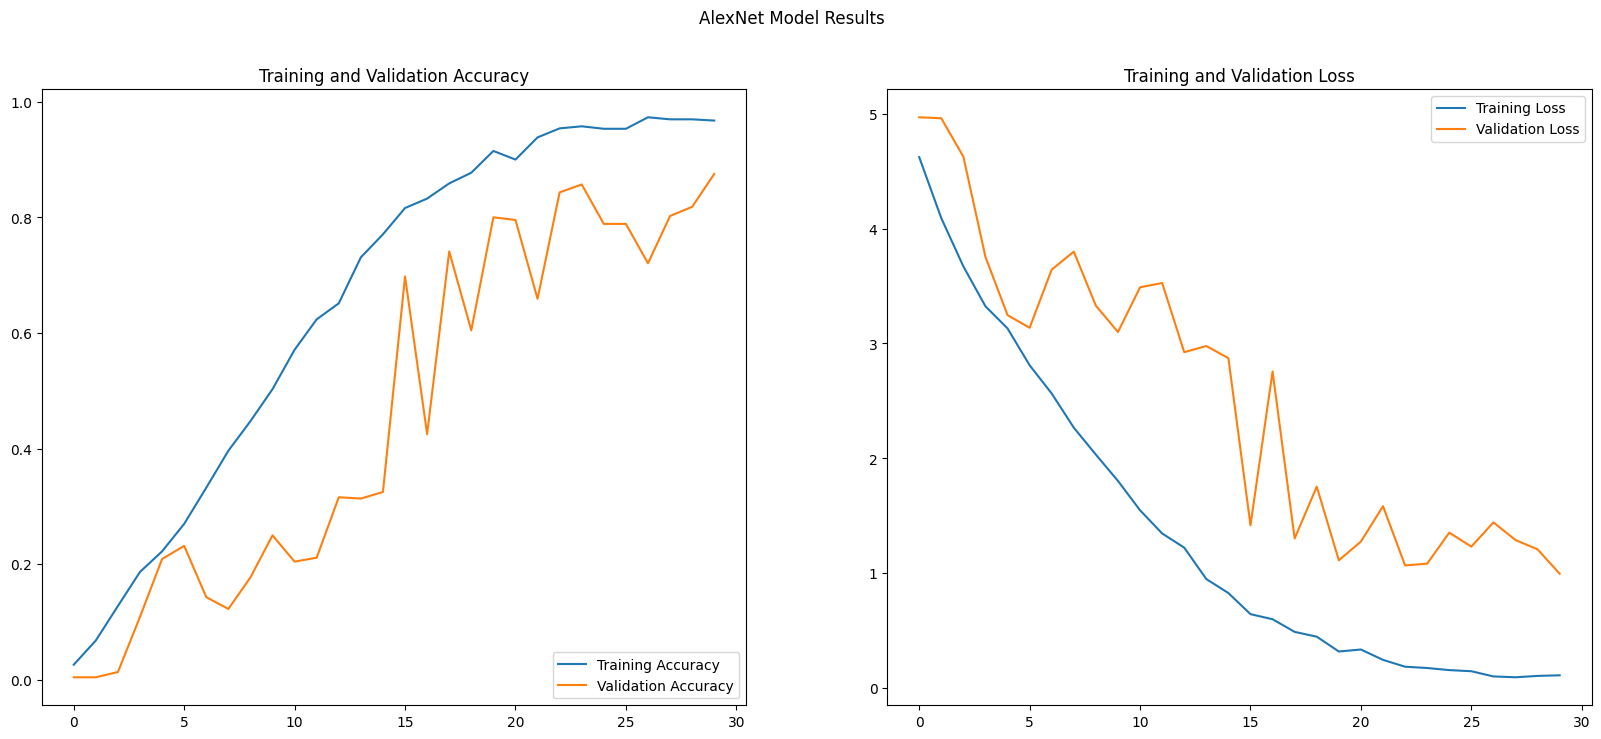

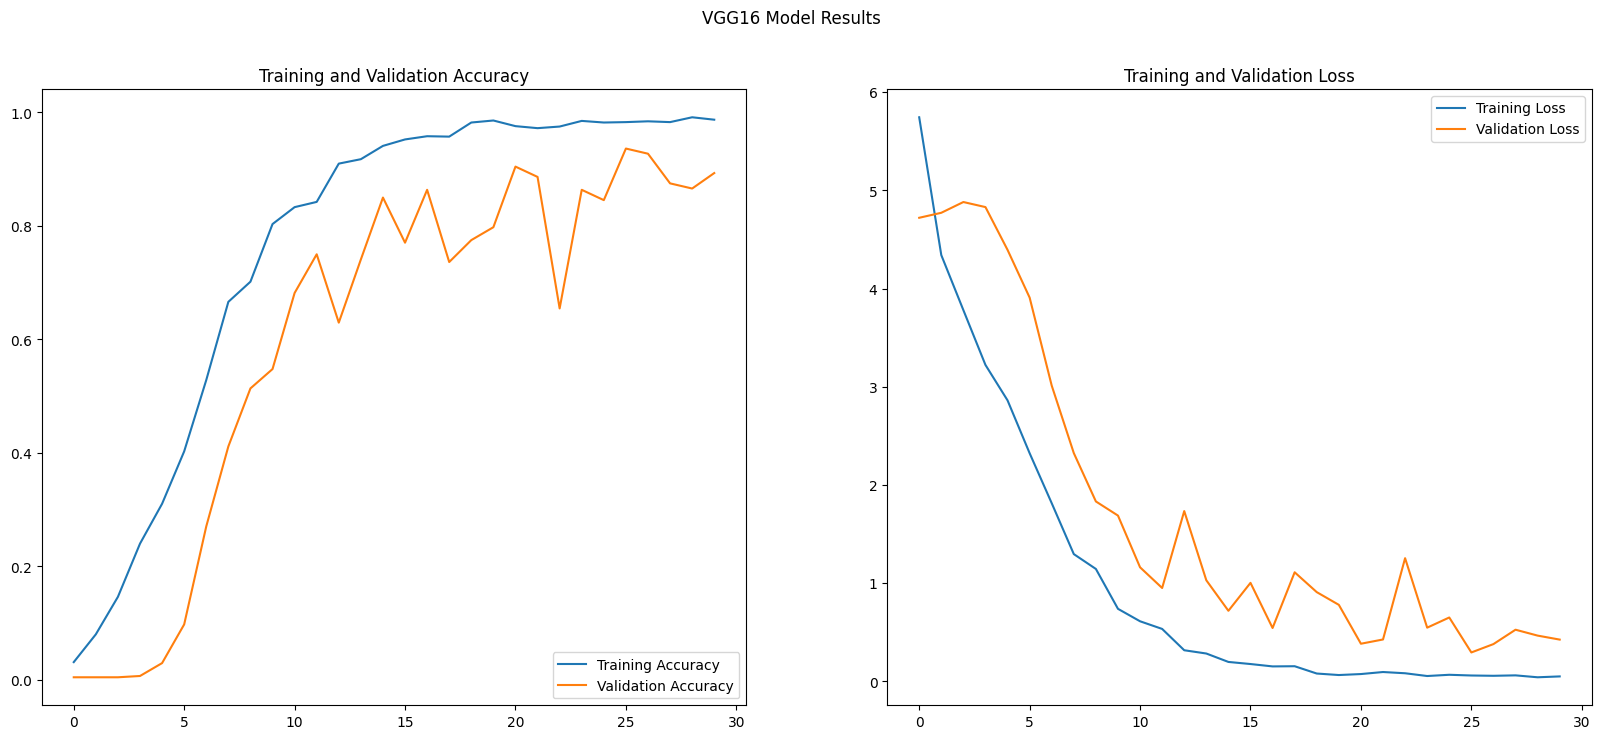

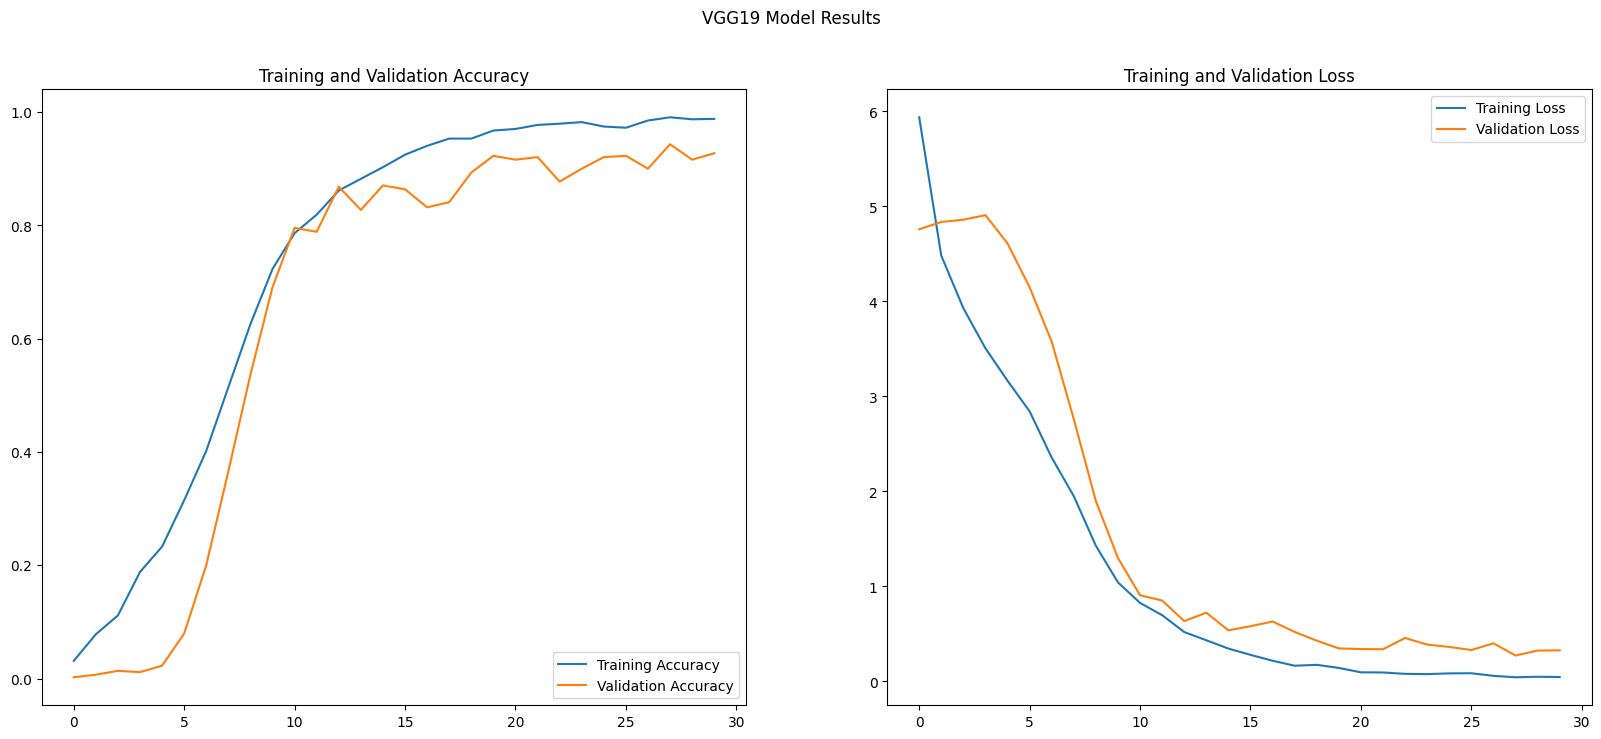

In [16]:
for name, history in model_histories.items():
    plot_model_performance(name, history)

In [17]:
for name, model in models.items():
    test_loss, test_accuracy = model.evaluate(test_dataset)

    print(f'\x1b[34m{name} Model Results:\x1b[0m')
    print(f"Test accuracy: {test_accuracy*100:.2f}%")
    print(f"Test loss: {test_loss:.4f}")
    print()

11/11 [==============================] - 1s 27ms/step - loss: 0.1383 - accuracy: 0.9688
AlexNet Model Results:
Test accuracy: 96.88%
Test loss: 0.1383

11/11 [==============================] - 2s 59ms/step - loss: 0.1069 - accuracy: 0.9744
VGG16 Model Results:
Test accuracy: 97.44%
Test loss: 0.1069

11/11 [==============================] - 2s 64ms/step - loss: 0.0481 - accuracy: 0.9886
VGG19 Model Results:
Test accuracy: 98.86%
Test loss: 0.0481



Saving models and their training histories

In [18]:
for name, model in models.items():
    model.save(f'Saved Models/VERA/{name}-30-Epochs.keras')
    print(f'Saved {name} Model')

for name, model in model_histories.items():
    with open(f'Model Histories/VERA/{name}.json', 'w') as json_file:
        json.dump(history.history, json_file)


Saved AlexNet Model
Saved VGG16 Model
Saved VGG19 Model


In [19]:
# img = keras.utils.load_img(
#     "Full Data/roi/001-M/01/001_L_1_1.png", target_size=image_size
# )
# plt.imshow(img)

# img_array = keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)

# predictions = model.predict(img_array)
# predicted_class_index = tf.argmax(predictions[0]).numpy()
# print('Predicted Class:', predicted_class_index)